# Shallow regression for vector data

This script reads zip code data produced by **vectorDataPreparations** and creates a machine learning model for
predicting the average zip code income from population and spatial variables.

It assess the model accuracy with a test dataset but also predicts the number to all zip codes and writes it to a geopackage
for closer inspection

# 1. Read the data

In [1]:
import time
import geopandas as gpd
import pandas as pd
from math import sqrt
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor,ExtraTreesRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

### 1.1 Input and output file paths 

In [2]:
paavo_data = "../data/paavo"

### Relative path to the zip code geopackage file that was prepared by vectorDataPreparations.py
input_geopackage_path = os.path.join(paavo_data,"zip_code_data_after_preparation.gpkg")

### Output file. You can change the name to identify different regression models
output_geopackage_path = os.path.join(paavo_data,"median_income_per_zipcode_shallow_model.gpkg")

### 1.2 Read the input data to a Geopandas dataframe

In [3]:
original_gdf = gpd.read_file(input_geopackage_path)
original_gdf.head()

,postinumer,nimi,hr_mtu,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,...,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi,geometry
0,00100,Helsinki Keskusta - Etu-Töölö,27577.0,-0.199953,-1.168668,-0.409187,5.500395,5.625018,5.353739,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,Punavuori,27523.0,-0.195383,-1.173029,-0.416345,1.761951,1.820420,1.694929,-0.999903,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,Kaartinkaupunki,30479.0,-0.189480,-1.172841,-0.416290,-0.108930,-0.097516,-0.121027,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,Kaivopuisto - Ullanlinna,29439.0,-0.188239,-1.176172,-0.414434,2.014145,2.166351,1.845281,-0.831997,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,Eira - Hernesaari,26546.0,-0.197130,-1.178021,-0.412826,2.499950,2.629719,2.354273,-0.999903,...,0,0,0,0,0,0,0,1,0,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


# 2. Train the model 

You can try different regressor models by uncommenting the corresponding lines. You can also try different modeling parameters. 

Which one is the best model? Can you figure out how to improve it even more?

### 2.1 Split the dataset to train and test datasets

In [5]:
### Split the gdf to x (the predictor attributes) and y (the attribute to be predicted)
y = original_gdf['hr_mtu'] # Average income

### Remove geometry and textual fields
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Split the both datasets to train (80%) and test (20%) datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)


### 2.2 These are the functions used for training, estimating and predicting.

In [11]:
def trainModel(x_train, y_train, model):
    start_time = time.time()  
    print(model)
    model.fit(x_train,y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    return model

def estimateModel(x_test,y_test, model):
    ### Predict the unemployed number to the test dataset
    prediction = model.predict(x_test)
    
    ### Assess the accuracy of the model with root mean squared error, mean absolute error and coefficient of determination r2
    rmse = sqrt(mean_squared_error(y_test, prediction))
    mae = mean_absolute_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)

    print(f"\nMODEL ACCURACY METRICS WITH TEST DATASET: \n" +
          f"\t Root mean squared error: {round(rmse)} \n" +
          f"\t Mean absolute error: {round(mae)} \n" +
          f"\t Coefficient of determination: {round(r2,4)} \n")

### Run different models

### Gradient Boosting Regressor
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#regression

In [8]:
model = GradientBoostingRegressor(n_estimators=30, learning_rate=0.1,verbose=1)
model_name = "Gradient Boosting Regressor"
trainModel(x_train, y_train,model)
estimateModel(x_test,y_test, model)

GradientBoostingRegressor(n_estimators=30, verbose=1)
      Iter       Train Loss   Remaining Time 
         1     8668381.1560            0.95s
         2     7527263.4187            0.91s
         3     6578597.1849            0.89s
         4     5770589.0947            0.86s
         5     5087152.9130            0.82s
         6     4510100.2753            0.79s
         7     4031858.3436            0.75s
         8     3634256.0016            0.72s
         9     3296767.1062            0.69s
        10     3007253.3094            0.65s
        20     1627021.2128            0.33s
        30     1220796.5502            0.00s
Model training took:  1.01  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1231 
	 Mean absolute error: 910 
	 Coefficient of determination: 0.8383 



### Random Forest Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#forest

In [12]:
model = RandomForestRegressor(n_estimators=30,verbose=1)
model_name = "Random Forest Regressor"
trainModel(x_train, y_train,model)
estimateModel(x_test,y_test, model)

RandomForestRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  2.41  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1162 
	 Mean absolute error: 849 
	 Coefficient of determination: 0.856 



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


### Extra Trees Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [10]:
model = ExtraTreesRegressor(n_estimators=30,verbose=1)
model_name = "Extra Trees Regressor"
trainModel(x_train, y_train,model)
estimateModel(x_test,y_test, model)

ExtraTreesRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  1.08  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1131 
	 Mean absolute error: 831 
	 Coefficient of determination: 0.8636 



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


### Bagging Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#bagging

In [15]:
model = BaggingRegressor(n_estimators=30,verbose=1)
model_name = "Bagging Regressor"
trainModel(x_train, y_train,model)
estimateModel(x_test,y_test, model)

BaggingRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training took:  2.5  seconds

MODEL ACCURACY METRICS WITH TEST DATASET: 
	 Root mean squared error: 1200 
	 Mean absolute error: 854 
	 Coefficient of determination: 0.8463 



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


### AdaBoost Regressor

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
* https://scikit-learn.org/stable/modules/ensemble.html#adaboost

In [ ]:
model = AdaBoostRegressor(n_estimators=30)
model_name = "AdaBoost Regressor"
trainModel(x_train, y_train,model)
estimateModel(x_test,y_test, model)

# 3. Predict average income to all zip codes
Here we predict the average income to the whole dataset. Prediction is done with the model you have stored in the model variable - the one you ran last

In [16]:
### Print chosen model (the one you ran last)
print(model)

### Drop the not-used columns from original_gdf as done before model training.
x = original_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

### Predict the median income with already trained model
prediction = model.predict(x)

### Join the predictions to the original geodataframe and pick only interesting columns for results
original_gdf['predicted_hr_mtu'] = prediction.round(0)
original_gdf['difference'] = original_gdf['predicted_hr_mtu'] - original_gdf['hr_mtu']
resulting_gdf = original_gdf[['postinumer','nimi','hr_mtu','predicted_hr_mtu','difference','geometry']]

BaggingRegressor(n_estimators=30, verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<AxesSubplot:title={'center':'Predicted average income by zip code Bagging Regressor'}>

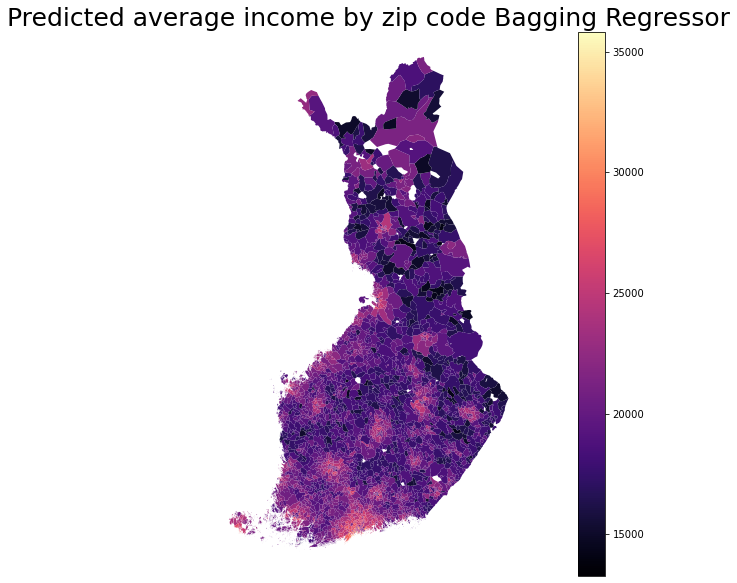

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Predicted average income by zip code " + model_name, fontsize=25)
ax.set_axis_off()
resulting_gdf.plot(column='predicted_hr_mtu', ax=ax, legend=True, cmap="magma")

# 4. EXERCISE: Calculate the difference between real and predicted incomes

Calculate the difference of real and predicted income amounts by zip code level and plot a map of it

* **original_gdf** is the original dataframe
* **resulting_gdf** is the predicted one

In [ ]:
#### This is what students might do here
resulting_gdf['diff'] = resulting_gdf['predicted_hr_mtu'] - resulting_gdf['hr_mtu']
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Difference in average income by zip code", fontsize=25)
ax.set_axis_off()
resulting_gdf.plot(column='diff', ax=ax, legend=True, cmap="BrBG")